# CRIAÇÃO DO MODELO PREDITIVO
O notebook foi executado no [Colab](https://colab.research.google.com/).
> versão de python utilizada para o pipeline: 3.8.10


In [ ]:
%pip install sklearn
%pip install matplotlib
%pip install pandas
%pip install numpy

In [ ]:
from sklearn.preprocessing import RobustScaler


SCALER = RobustScaler()
CMAPS = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 
         'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 
         'PuBuGn', 'BuGn', 'YlGn']

FEATURES = ['FirstOrder', 'GLCM', 'GLRLM', 'GLSZM', 'NGTDM', 
            'GLDM', 'lbp', 'haralick', 'tas', 'zernike']
MLP_KWARGS = dict(alpha=0.0001, learning_rate_init=0.01, max_iter=500, 
                  random_state=42)

HARALICK_LABELS = (
    "Angular Second Moment",
    "Contrast",
    "Correlation",
    "Sum of Squares: Variance",
    "Inverse Difference Moment",
    "Sum Average",
    "Sum Variance",
    "Sum Entropy",
    "Entropy",
    "Difference Variance",
    "Difference Entropy",
    "Information Measure of Correlation 1",
    "Information Measure of Correlation 2",
    "Maximal Correlation Coefficient"
)

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt 
import sklearn.metrics as mt 
import pandas as pd
import numpy as np

def humanize_haralick(df: pd.DataFrame) -> None:
    renamer = {f'haralick_{i}': f'haralick_{label}' for i, label in enumerate(HARALICK_LABELS)}
    df.rename(columns=renamer, inplace=True)

def filter_numeric_data(df: pd.DataFrame) -> None:
    col = df.select_dtypes(include=['object']).columns
    df.drop(columns=col, inplace=True)

def get_metrics(y: np.ndarray, y_pred: np.ndarray) -> dict:
        vn, fp, fn, vp = mt.confusion_matrix(y_test, y_pred).reshape(-1)
        accuracy = (vp + vn) / (vp + fp + fn + vn)
        recall = vp / (vp + fn)
        specificity = vn / (vn + fp)
        precision = vp / (vp + fp)

        return {
            'f1-score': (2 * precision * recall) / (precision + recall),
            'accuracy': accuracy,
            'specificity': specificity,
            'recall': recall,
            'precision': precision,
        }

def plot_confusion_matrix(model, X, y, cmap='Blues', return_values=False,
                          _ax=None, x_pos=2.20, y_pos=0.50, offset=0.1,
                          rect_dim=[1.00, 0.65], title=None) -> None:
    offsets = np.arange(-2, 3, 1, dtype='float') * offset
    _, ax = plt.subplots() if _ax is None else (..., _ax)

    # Plotando a matriz de confusão do classificador
    try:
        mt.ConfusionMatrixDisplay.from_estimator(
            model, X, y, 
            cmap=cmap, 
            ax=ax,
            display_labels=['Saudável', 'COVID-19']
            )
    except:
        y_pred = model.predict(X)
        cm = mt.confusion_matrix(y, y_pred)
        mt.ConfusionMatrixDisplay(
            cm, 
            display_labels=['Saudável', 'COVID-19']
            ).plot(cmap=cmap, ax=ax)
    
    # Adicionando as métricas de avaliação do modelo ao plot
    metrics = get_metrics(y, model.predict(X))
    for offset, [key, value] in zip(offsets, metrics.items()):
        ax.text(x_pos, y_pos + offset, f'• {key}: {value:.3f}', clip_on=False)
    ax.add_patch(Rectangle((x_pos - 0.05, y_pos - .35), *rect_dim, fill=True, 
                           color ='wheat', clip_on=False))
    ax.add_patch(Rectangle((x_pos - 0.05, y_pos - .35), *rect_dim, fill=False, 
                           color ='black', clip_on=False))
    ax.set_title(title or 'Matriz de Confusão')
    ax.figure.set_facecolor('white')
    
    if _ax is None:
        plt.show()

def features_metrics(row: pd.DataFrame, ax, **kwargs) -> None:
    plot_confusion_matrix(row.model, row.X_test, y_test, cmap=row.cm, 
                          _ax=ax[row.idxrow, row.idxcol],
                          title=f'Matriz de Confusão ({row.feature})', 
                          **kwargs)    

#   

In [ ]:
# Leitura do dataset com as features extraidas
df = pd.read_csv('./features.csv')

# Filtrando e configurando o dataset
humanize_haralick(df) # renomeando as colunas do haralick
df.query('dataset != "CovidChestXray"', inplace=True) # drop de um dataset
df.reset_index(drop=True, inplace=True)
filter_numeric_data(df) # dropando tudo que não for numérico
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36411 entries, 0 to 36410
Columns: 196 entries, covid to zernike_24
dtypes: float64(195), int64(1)
memory usage: 54.4 MB


In [ ]:
df.head()

,covid,FirstOrder_10Percentile,FirstOrder_90Percentile,FirstOrder_Energy,FirstOrder_Entropy,FirstOrder_InterquartileRange,FirstOrder_Kurtosis,FirstOrder_Maximum,FirstOrder_MeanAbsoluteDeviation,FirstOrder_Mean,...,zernike_15,zernike_16,zernike_17,zernike_18,zernike_19,zernike_20,zernike_21,zernike_22,zernike_23,zernike_24
0,0,0.0,191.0,9.709251e+08,3.096083,113.0,1.751209,247.0,57.410444,102.409271,...,0.009856,0.022007,0.012353,0.010825,0.012543,0.017980,0.018095,0.012096,0.006164,0.013499
1,0,0.0,192.0,1.125011e+09,3.060981,103.0,1.992342,255.0,55.204972,113.854813,...,0.003432,0.019492,0.019578,0.012758,0.011509,0.014110,0.010219,0.008465,0.005679,0.009768
2,0,17.0,226.0,1.373326e+09,3.297752,123.0,1.867981,250.0,63.194600,124.776581,...,0.007926,0.012548,0.014127,0.022806,0.010537,0.014966,0.020339,0.010417,0.017469,0.008866
3,0,10.0,203.0,9.967243e+08,3.237558,105.0,1.987831,253.0,57.648158,103.447189,...,0.001976,0.020846,0.015946,0.013781,0.022732,0.005295,0.003268,0.047119,0.001570,0.016309
4,0,2.0,210.0,1.384229e+09,2.938695,142.0,1.916761,255.0,62.878649,125.180954,...,0.008407,0.016923,0.020657,0.022265,0.026174,0.016327,0.004019,0.021849,0.007513,0.006639


In [ ]:
# Esta coluna representa o diagnóstico de covid
# onde 1 é positivo e 0 negativo.
df['covid'].value_counts()

0    20892
1    15519
Name: covid, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Separação treino/teste para o pipeline do modelo preditivo.
X = SCALER.fit_transform(df.iloc[:, 1:])
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

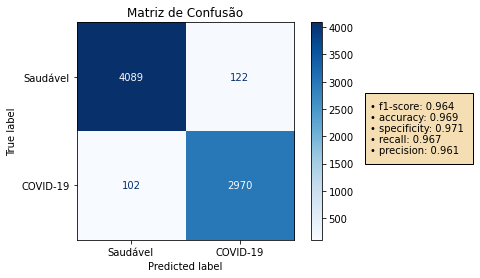

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(**MLP_KWARGS) # Instanciação do modelo preditivo
model.fit(X_train, y_train) # Treinando o modelo

# plot da matriz de confusão + métricas de avaliação do modelo
fig, ax = plt.subplots() # Criando um plot do matplotlib
plot_confusion_matrix(model, X_test, y_test, _ax=ax) 

In [ ]:
%pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier

lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, 
                          predictions=True, random_state=42)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)

best_models = models.sort_values(by='Accuracy', ascending=False).iloc[:9].index
top10_models = predictions[best_models]
top10_models['MLPClassifier'] = model.predict(X_test)

In [ ]:
df_metrics = pd.DataFrame.from_records(top10_models.apply(lambda y_pred: get_metrics(y_test, y_pred)))
df_metrics.index = top10_models.columns
df_metrics.index.name = 'Models'
df_metrics.sort_values(by=df_metrics.columns.to_list(), ascending=False, inplace=True)

top10_models = models.sort_values(by='Accuracy', ascending=False).iloc[:10]
models_df = pd.DataFrame.from_records(predictions[top10_models].apply(lambda x: {'model': x.name, **get_metrics(y_test, x)}).values)
models_df = models_df.append({'model': 'MLPClassifier', **get_metrics(y_test, model.predict(X_test))}, ignore_index=True)
pd.options.display.float_format = '{:.4f}'.format
predictions.info()

In [ ]:
# Pipeline para visualização das métricas isolada de cada feature do dataset
data = {'feature': [], 'model': [], 'X_train': [], 'X_test': []}

for name in FEATURES:
    lbl = name.upper() if name.islower() else name
    filtered_data = df.filter(like=name)
    
    # Transformando os dados em escala, para otimização dos cálculos
    Xf = SCALER.fit_transform(filtered_data)

    # Separação treino/teste
    Xf_train, Xf_test = train_test_split(Xf, test_size=0.2, random_state=42)
    
    # Instanciação do modelo + treinamento
    feature_model = MLPClassifier(**MLP_KWARGS)
    feature_model.fit(Xf_train, y_train)

    # armazenando os valores dentro da variável @data
    data['feature'].append(lbl)
    data['model'].append(feature_model)
    data['X_train'].append(Xf_train)
    data['X_test'].append(Xf_test)

models_pipeline = pd.DataFrame.from_dict(data)

In [ ]:
from itertools import product

# Configuração para o plot das matrizes de confusões do modelo com as
# características isoladas
grid = [ncol, nrow] = np.array([2, 5])
indexer = product(*map(range, grid))
idx_arr = np.array([*indexer], dtype='uint8')

idxcol, idxrow = np.hsplit(idx_arr, 2)
models_pipeline['cm'] = CMAPS[:models_pipeline.shape[0]]

try:
    models_pipeline[['idxcol', 'idxrow']] = idx_arr
except:
    models_pipeline['idxcol'] = idxcol.reshape(-1)
    models_pipeline['idxrow'] = idxrow.reshape(-1)

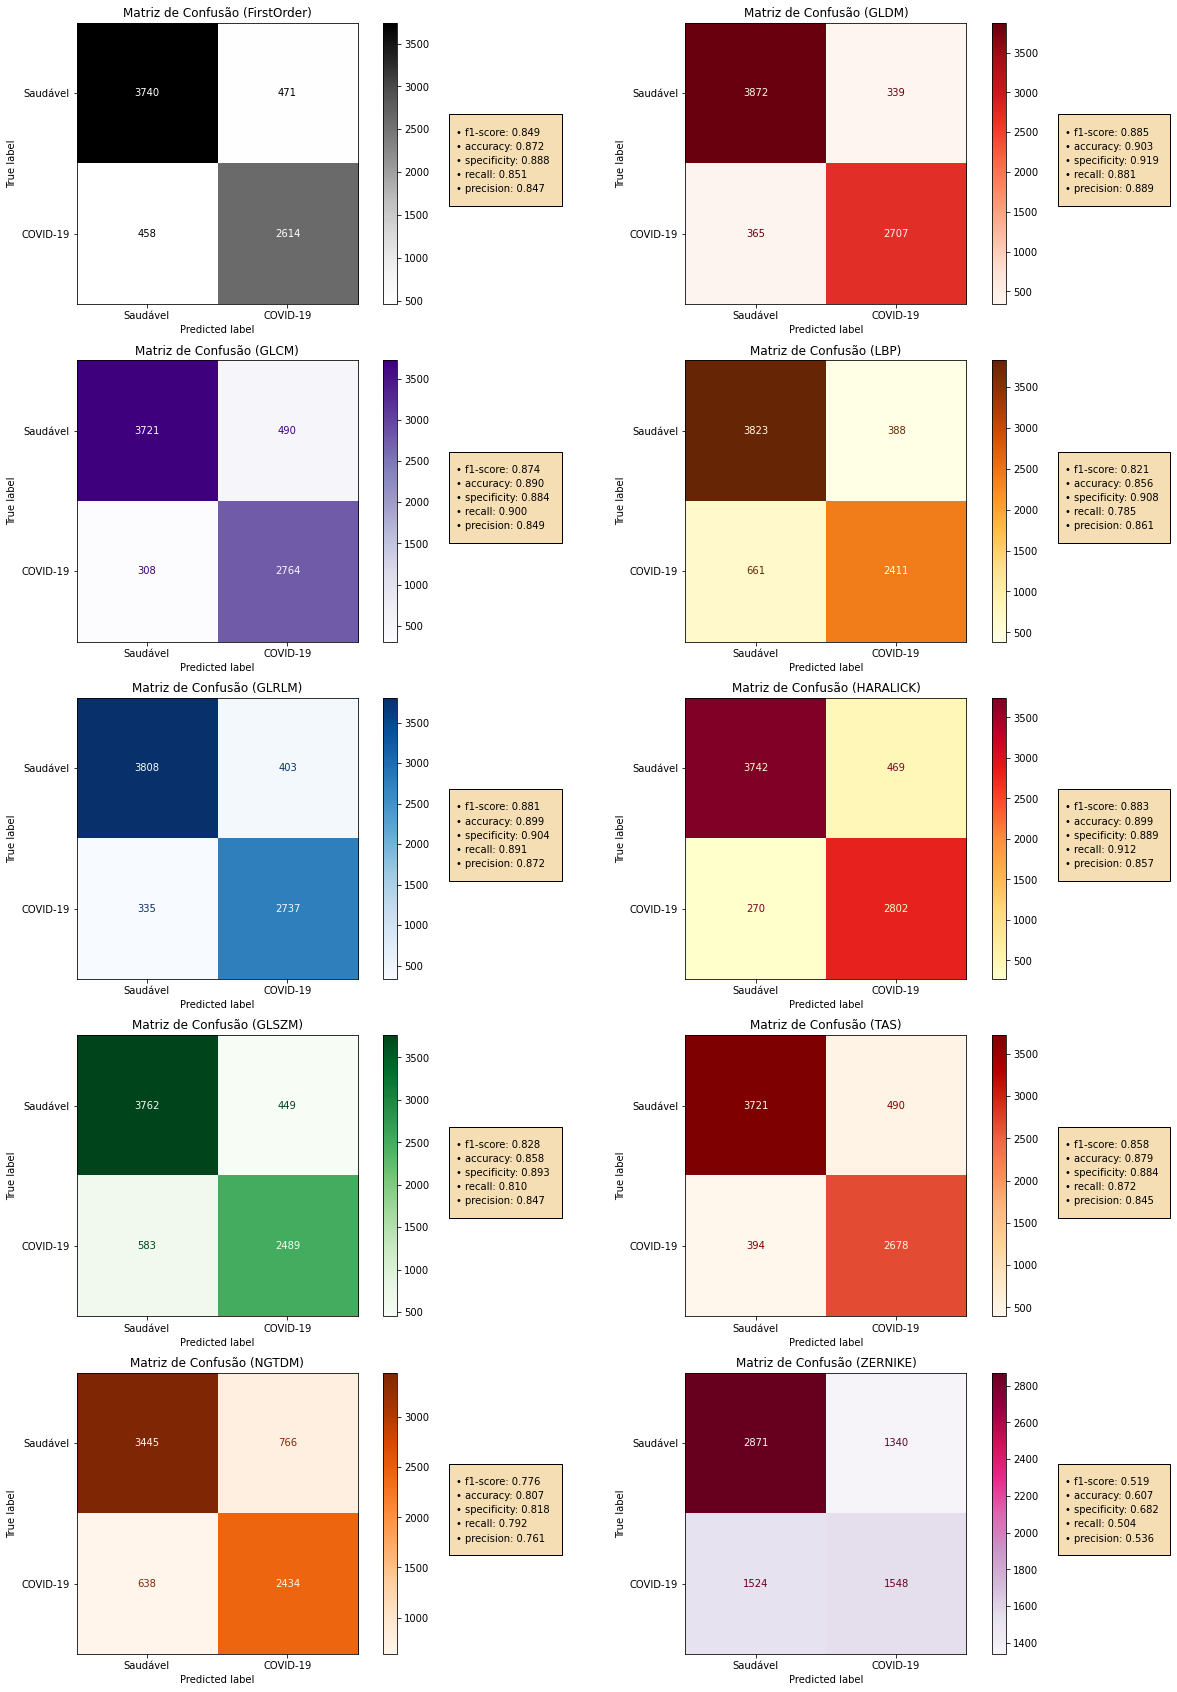

In [ ]:
fig_size = np.array([10, 6])

fig, ax = plt.subplots(nrow, ncol, figsize=fig_size * grid)
models_pipeline.apply(features_metrics, args=(ax,), 
                      axis=1, rect_dim=[.8, .65])

fig.set_facecolor('white')
plt.show()

In [ ]:
%pip install jupyter --upgrade

In [ ]:
%pip install tpot

In [ ]:
from tpot import tpot

tpot_clf = tpot.TPOTClassifier(
    generations=30, 
    population_size=10, 
    scoring='f1', 
    n_jobs=-1, 
    early_stop=5, 
    random_state=42,  
    verbosity=2, 
    warm_start=True
)

tpot_clf.fit(X_train, y_train) # treinamento do modelo do TPOT
tpot_clf.export('best_pipeline.py') # criando o arquivo .py do pipeline

# plot da matriz de confusão + métricas de avaliação do modelo
fig, ax = plt.subplots() # Criando um plot do matplotlib
plot_confusion_matrix(tpot_clf, X_test, y_test, _ax=ax) 

In [ ]:
%pip install pip --upgrade
%pip install pycaret
%pip install numpy --upgrade

In [ ]:
import pycaret.classification as pyc_clf
clf = pyc_clf.setup(
    data=df, target='covid', session_id=42, train_size=0.8, verbose=True, 
    normalize=True, normalize_method='robust', n_jobs=-1)
pyc_clf.compare_models()